# Statistical Methodological Comparison Notebook
The point of this notebook is to walk the user through a numpyro-based comparitive analysis of a hierarchical model and two non-hierarchical models (full pooling and unpooled).

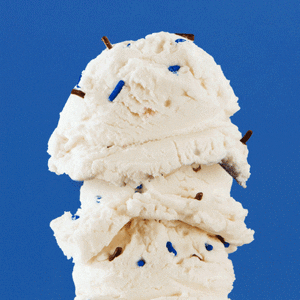

Hierarchical models are like ice cream; each layer of stack mixes with the other layers, lending them inference power. This notebook steps out to demonstrate empirically that hierarchical models are more powerful and here we carry out a careful treatment of the uncertainty quantification.

## The dataset: simple pendulum
Using the position of a pendulum at one point in time from a collection of pendulums on two different planets, determine the values of L, $\theta$, and $a_g$ for each individual pendulum using a hierarchical setup.

In [1]:
## first, import all the necessary modules
import arviz as az
import corner
import graphviz
import jax
from jax import random
import jax.numpy as jnp # yes i know this is confusing
import matplotlib.pyplot as plt
import numpy as np
import numpyro

from numpyro.util import enable_x64

enable_x64()

## in numpyro, you must specify number of sampling chains you will use upfront

# words of wisdom from Tian Li and crew:
# on gpu, don't use conda, use pip install
# HMC after SBI to look at degeneracies between params
# different guides (some are slower but better at showing degeneracies)

## define the platform and number of cores (one chain per core)
numpyro.set_platform('cpu')
core_num = 4
numpyro.set_host_device_count(core_num)

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
## plotting and analysis utilities

def display_pendulum_data(df):
    ## plot all pendulums and pendulums color-coded by planet
    color_list = ['#BCF4F5', '#B4EBCA', '#D9F2B4', '#D3FAC7',
                  '#FFB7C3', '#2F2F2F', '#4A4063', '#FE5E41']
    index = 0
    for pend in np.unique(df['pendulum_id']):
        subset = df[df['pendulum_id']==pend]
        plt.plot(subset['time'], subset['pos'],
                    color = color_list[index],
                    label = pend)
        plt.scatter(subset['time'], subset['pos'],
                    color = color_list[index])
        index+=1
    plt.legend()
    plt.xlabel('time [s]')
    plt.ylabel('x position')
    plt.show()

    index = 0
    for planet in np.unique(df['planet_id']):
        subset = df[df['planet_id']==planet]
        plt.plot(subset['time'], subset['pos'],
                    color = color_list[index],
                    label = planet)
        plt.scatter(subset['time'], subset['pos'],
                    color = color_list[index])
        if planet > 3:
            break
        index+=1
    plt.legend()
    plt.xlabel('time [s]')
    plt.ylabel('x position')
    plt.title('pendulums color-coded by planet')
    plt.show()
    
def plot_prior_predictive(prior_pred, variable_model, variable_df, n_steps=10, title = None):
    ## plot the prior predictive histograms for parameters in the model
    label = "prior samples"
    plt.hist(
        prior_pred[variable_model].flatten(),
        n_steps,
        #range=(0.2, 3.0),
        #histtype="step",
        color="k",
        lw=0.5,
        alpha=0.5,
        label=label,
        density=True
    )
    plt.hist(df[variable_df], n_steps, histtype="step", color="black", label="data", density=True)
    plt.legend()
    plt.xlabel(variable_model)
    plt.ylabel("density")
    plt.title(title)
    plt.show()

def pos_calculator(L, theta, a_g, sigma, time):
    ## because the sampler chain doesn't save the position at each point in time,
    ## i have created a thing that samples position for us
    pos = L * np.sin(theta * np.cos(np.sqrt(a_g / L) * time)) + sigma * np.random.randn(len(time))
    return pos

def how_did_we_do_on_individual_pendulums(df, posterior, n_pendulums, chain_length, pooled = False):
    ## print out the mean and standard deviation on the posterior parameters for
    ## each individual pendulum and make multiple draws from the posterior distribution
    ## to plot "theoretical" pendulum trajectories
    for number in range(n_pendulums):
        sub_df = df[df['pend_code'] == number]
        print(f"Pendulum number {number}")
        print(f"true L = {np.mean(sub_df['length'].values)}")
        print(f"posterior L = {round(np.median(posterior['L'][:,number]),2)} +/- {round(np.std(posterior['L'][:,number]),2)}")
        print(f"true theta = {np.mean(sub_df['theta'].values)}")
        print(f"posterior theta = {round(np.median(posterior['theta'][:,number]),2)} +/- {round(np.std(posterior['theta'][:,number]),2)}")
        print(f"true a_g = {np.mean(sub_df['a_g'].values)}")
        if pooled:
            print(f"posterior a_g = {round(np.median(posterior['a_g'][:]),2)} +/- {round(np.std(posterior['a_g'][:]),2)}")
        else:
            print(f"posterior a_g = {round(np.median(posterior['a_g'][:,number]),2)} +/- {round(np.std(posterior['a_g'][:,number]),2)}")
        # let's actually draw from this posterior:
        plt.clf()

        
        for j in range(chain_length):
            L = posterior['L'][j,number]
            theta = posterior['theta'][j,number]
            if pooled:
                a_g = posterior['a_g'][j]
            else:
                a_g = posterior['a_g'][j,number]#FIXXXXX
            sigma = posterior['σ'][j]
            plt.plot(times, pos_calculator(L,theta,a_g,sigma,times), color = 'grey')
        plt.scatter(sub_df['time'].values, sub_df['pos'].values, zorder=100, color = 'orange')
        plt.show()

def how_did_we_do_on_all_pendulums(df, posterior, n_pendulums, chain_length):
    ## plot the 3 sigma position intervals from these posteriors for all pendulums at once
    ## (should probably redo this to more cleanly see each pendulum individually)
    n_pendulums = 8
    chain_length = 2000
    # first do the first four pendulums
    # hot colors
    colors = ['#F26419', '#F6AE2D', '#820263', '#D90368']
    plt.clf()

    offset = 0
    counter_neg = 0
    for number in range(4):
        sub_df = df[df['pend_code'] == number]
        # let's actually draw from this posterior:


        y_model = np.zeros((chain_length, len(times)))

        # I need to grab this from the end of the chain (most accurate)
        for j in range(chain_length):
            L = posterior['L'][j,number]
            theta = posterior['theta'][j,number]
            try:
                a_g = posterior['a_g'][j,number]#FIXXXXX
            except IndexError: # for the unpooled case
                a_g = posterior['a_g'][j]
            sigma = posterior['σ'][j]
            # Instead of plotting can I combine the lines?
            if L < 0 or a_g < 0:
                counter_neg += 1
            y_model[j,:] = pos_calculator(abs(L),theta,abs(a_g),sigma,times)
            #if j > 100:
            #    break
        y_average = np.mean(y_model, axis=0)
        y_std = np.std(y_model, axis=0)
        plt.fill_between(times, y_average + offset - 3 * y_std, y_average + offset + 3 * y_std, color=colors[number],
                         alpha=0.5, label='Standard Deviation')
        #plt.plot(times, y_average + offset, color = colors[number])
        #plt.scatter(sub_df['time'].values, sub_df['pos'].values + offset, zorder=100, color = colors[number])
        plt.axhline(y = offset, color = 'black')
        offset += 1 #* (number + 1)
        
    print('NUMER OF NEGATIVE PARAMS', counter_neg)
    plt.title('Pendulums on planet 1')
    plt.ylabel('each subsequent pendulum is offset by +15')
    plt.show()
    

    # second four pendulums (from planet 2) are cool colors
    colors = ['#33658A', '#86BBD8', '#2F4858', '#6CC551']
    plt.clf()
    offset = 0
    for number in range(4):
        number_2 = number + 3
        sub_df = df[df['pend_code'] == number_2]
        # let's actually draw from this posterior:


        y_model = np.zeros((chain_length, len(times)))

        # I need to grab this from the end of the chain (most accurate)
        for j in range(chain_length):
            L = posterior['L'][j,number_2]
            theta = posterior['theta'][j,number_2]
            try:
                a_g = posterior['a_g'][j,number_2]#
            except IndexError:
                a_g = posterior['a_g'][j]
            sigma = posterior['σ'][j]
            # Instead of plotting can I combine the lines?
            y_model[j,:] = pos_calculator(abs(L),theta,abs(a_g),sigma,times)
            #if j > 100:
            #    break
        y_average = np.mean(y_model, axis=0)
        y_std = np.std(y_model, axis=0)
        plt.fill_between(times, y_average + offset - 3 * y_std, y_average + offset + 3 * y_std, color=colors[number],
                         alpha=0.5, label='Standard Deviation')
        plt.plot(times, y_average + offset, color = colors[number])
        plt.scatter(sub_df['time'].values, sub_df['pos'].values + offset, zorder=100, color = colors[number])
        plt.axhline(y = offset, color = 'black')
        offset += 1
    plt.title('Pendulums on planet 2')
    plt.ylabel('each subsequent pendulum is offset by +15')
    plt.show()

def make_corner_plots(posterior, data_params, pooled = False):
    data = az.from_dict(
        posterior={"L0": posterior["L"][:,0], "L1": posterior["L"][:,1],
                   "L2": posterior["L"][:,2], "L3": posterior["L"][:,3],
                   "L4": posterior["L"][:,4], "L5": posterior["L"][:,5],
                   "L6": posterior["L"][:,6], "L7": posterior["L"][:,7],
                   },
   #     sample_stats={"diverging": posterior["L"][:,0] < 9.0},
    )
    plt.clf()
    figure = corner.corner(data, divergences=True, truths = data_params['length'], truth_color = '#D84797')#,
                           #range = [(5,20),(5,20),(5,20),(5,20),(5,20),(5,20),(5,20),(5,20)])
    plt.show()

    data = az.from_dict(
        posterior={"theta0": posterior["theta"][:,0], "theta1": posterior["theta"][:,1],
                   "theta2": posterior["theta"][:,2], "theta3": posterior["theta"][:,3],
                   "theta4": posterior["theta"][:,4], "theta5": posterior["theta"][:,5],
                   "theta6": posterior["theta"][:,6], "theta7": posterior["theta"][:,7],
                   },
        #sample_stats={"diverging": posterior["L"][:,0] < 9.0},
    )
    plt.clf()
    figure = corner.corner(data, truths = data_params['theta'], truth_color = '#D84797')
    plt.show()

    if pooled:
        plt.clf()
        plt.hist(posterior["a_g"], bins = 100)
        plt.axvline(x = data_params['a_g'][0])
        plt.axvline(x = data_params['a_g'][4])
        plt.show()
    else:
        data = az.from_dict(
            posterior={"ag0": posterior["a_g"][:,0], "ag1": posterior["a_g"][:,1],
                       #"L2": posterior["L"][:,2], "L3": posterior["L"][:,3],
                       #"L4": posterior["L"][:,4], "L5": posterior["L"][:,5],
                       #"L6": posterior["L"][:,6], "L7": posterior["L"][:,7],
                       },
            #sample_stats={"diverging": posterior["L"][:,0] < 9.0},
        )
        print(data_params['a_g'])
        plt.clf()
        figure = corner.corner(data, truths = [data_params['a_g'][0], data_params['a_g'][4]], truth_color = '#D84797')
        plt.show()
    data = az.from_dict(
        posterior={"ag0": posterior["a_g"][:,0], "ag1": posterior["a_g"][:,1],
                   "L0": posterior["L"][:,0], "L1": posterior["L"][:,1],
                   "L4": posterior["L"][:,4], "L5": posterior["L"][:,5],
                   #"L6": posterior["L"][:,6], "L7": posterior["L"][:,7],
                   },
        #sample_stats={"diverging": posterior["L"][:,0] < 9.0},
    )
    plt.clf()
    figure = corner.corner(data, truths = [data_params['a_g'][0], data_params['a_g'][4],
                                           data_params['length'][0], data_params['length'][1],
                                           data_params['length'][4], data_params['length'][5]], truth_color = '#D84797')
    plt.show()
    
def plot_posterior_predictive_samples(df, model, posterior, rng_key, time_values, mcmc_run,
                                      pooled,
                                      title,
                                      kind = 'kde'):
    
    planet_encoder = LabelEncoder()

    planets = planet_encoder.fit_transform(df["planet_code"])
    planets = jnp.array(planets)

    pendulum_encoder = LabelEncoder()

    pendulums = pendulum_encoder.fit_transform(df["pend_code"])
    pendulums = jnp.array(pendulums)

    pooled_posterior_predictive = numpyro.infer.Predictive(
        model=model, posterior_samples=posterior
    )
    '''
    prior_pred = numpyro.infer.Predictive(hierarchical_model, num_samples=50)(
        random.PRNGKey(11), planet_code, pend_code, time_values
    )
    '''
    rng_key, rng_subkey = random.split(rng_key)
    if pooled:
        print('pooled')
        pooled_posterior_predictive_samples = pooled_posterior_predictive(rng_subkey, pendulums, time_values)
    else:
        pooled_posterior_predictive_samples = pooled_posterior_predictive(rng_subkey, planets, pendulums, time_values)
    # convert to arviz inference data object
    pooled_idata = az.from_numpyro(
        posterior=mcmc_run, posterior_predictive=pooled_posterior_predictive_samples
    )
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 6))
    az.plot_ppc(
        data=pooled_idata,
        observed_rug=True,
        ax=ax,
        kind=kind,
    )
    ax.set(
        title=title,
        xlabel="observed position",
        ylabel="count",
    )
    plt.show()
    
    
    return pooled_posterior_predictive, pooled_posterior_predictive_samples, pooled_idata
    
def compare_models(pooled_idata, unpooled_idata, hierarchical_idata, kind = 'kde'):
    plt.clf()
    fig, ax = plt.subplots(
        nrows=1, ncols=3, figsize=(12, 5), sharex=True, sharey=True#, layout="constrained"
    )

    az.plot_ppc(
        data=pooled_idata,
        observed_rug=True,
        ax=ax[0],
        kind=kind,
    )
    ax[0].set(
        title="Pooled Model",
        xlabel="x pos",
        ylabel="count",
    )
    az.plot_ppc(
        data=unpooled_idata,
        observed_rug=True,
        ax=ax[1],
        kind=kind,
    )
    ax[1].set(
        title="Unpooled",
        xlabel="x pos",
        ylabel="count",
    )
    az.plot_ppc(
        data=hierarchical_idata,
        observed_rug=True,
        ax=ax[2],
        kind=kind,
    )
    ax[2].set(
        title="Hierarchical",
        xlabel="x pos",
        ylabel="count",
    )

    fig.suptitle("Posterior Predictive Checks", y=1.06, fontsize=16)
    plt.show()
    
def investigate_distribution_posteriors(posterior_samples, inf_data):
    ## investigate the distribution
    for num in range(8):
        heights, bins = np.histogram(posterior_samples['L'][:,num], bins = 100)
        height = np.max(heights)
        p3 = np.percentile(posterior_samples['L'][:,num], 3)
        p97 = np.percentile(posterior_samples['L'][:,num], 97)
        plt.hist(posterior_samples['L'][:,num], color = '#D84797', bins = 100)
        plt.axvline(x = az.summary(inf_data)['mean'][num], color = 'black')
        plt.text(az.summary(inf_data)['mean'][num], height, 'mean', color='black', ha='right', va='top', rotation=90)
        plt.axvline(x = az.summary(inf_data)['hdi_3%'][num], color = 'black')
        plt.text(az.summary(inf_data)['hdi_3%'][num], height, 'hdi_3%', color='black', ha='right', va='top', rotation=90)
        plt.axvline(x = az.summary(inf_data)['hdi_97%'][num], color = 'black')
        plt.text(az.summary(inf_data)['hdi_97%'][num], height, 'hdi_97%', color='black', ha='right', va='top', rotation=90)
        plt.axvline(x = az.summary(inf_data)['mean'][num] - az.summary(inf_data)['sd'][num], color = 'black')
        plt.text(az.summary(inf_data)['mean'][num] - az.summary(inf_data)['sd'][num], height, 'standard deviation', color='black', ha='right', va='top', rotation=90)
        plt.axvline(x = az.summary(inf_data)['mean'][num] + az.summary(inf_data)['sd'][num], color = 'black')
        plt.text(az.summary(inf_data)['mean'][num] + az.summary(inf_data)['sd'][num], height, 'standard deviation', color='black', ha='right', va='top', rotation=90)

        plt.axvline(x = p3, color = 'black')
        plt.text(p3, height, '3%', color='black', ha='right', va='top', rotation=90)
        plt.axvline(x = p97, color = 'black')
        plt.text(p97, height, '97%', color='black', ha='right', va='top', rotation=90)
        plt.show()
        
def examine_chains(posterior, data_params, n_pendulums = 8, chain_length = 5000, n_chains = 4):
    chain_colors = ['#B5CA8D',
                    '#8BB174',
                    '#426B69',
                    '#222E50']
    plt.clf()
    for p in range(n_pendulums-1):


        for chain in range(n_chains-1):
            plt.plot(posterior['L'][chain_length * chain : chain_length * chain + chain_length-1 , p],
                     color = chain_colors[chain])
        plt.axhline(y = data_params['length'][p], color = 'black')
    plt.ylim([1,25])
    plt.title('Length inference')
    plt.show()

    fig, axs = plt.subplots(2, 4, figsize=(10, 10))

    for p, ax in enumerate(axs.flatten()):
        ax.axvline(x = data_params['length'][p], color = 'black')

        for chain in range(n_chains-1):
            if chain == 0:
                values, bins = np.histogram(posterior['L'][:, p],
                                             bins = 20)
                #print('values', values)
                #print('bins', bins)
            ax.hist(posterior['L'][chain_length * chain : chain_length * chain + chain_length-1 , p],
                    bins = bins,
                    color = chain_colors[chain], histtype='bar', ec='white',
                    density = True)
        #ax.set_xlim([1,25])


    plt.show()

    plt.clf()
    for p in range(n_pendulums-1):


        for chain in range(n_chains-1):
            plt.plot(posterior['theta'][chain_length * chain : chain_length * chain + chain_length-1 , p],
                     color = chain_colors[chain])
        plt.axhline(y = data_params['theta'][p], color = 'black')
    plt.ylim([0, np.pi/2])
    plt.title('theta inference')
    plt.show()

    fig, axs = plt.subplots(2, 4, figsize=(10, 10))

    for p, ax in enumerate(axs.flatten()):
        ax.axvline(x = data_params['theta'][p], color = 'black')
        for chain in range(n_chains-1):
            if chain == 0:
                values, bins = np.histogram(posterior['theta'][:, p],
                                             bins = 20)
                #print('values', values)
                #print('bins', bins)
            ax.hist(posterior['theta'][chain_length * chain : chain_length * chain + chain_length-1 , p],
                    bins = bins,
                    color = chain_colors[chain], histtype='bar', ec='white',
                    density = True)
        #ax.set_xlim([1,25])


    plt.show()
        
print('compiled')

compiled


## Hierarchical model
Again, this is the full ice cream stack model. Here, there are global values (μ_a_g and σ_a_g), from which the individual a_g values are drawn for each planet. The a_g values get information from all pendulums on a given planet AND from the global values which also are informed by the pendulums on the other planet. The L and theta are sampled for each individual planet.

Note that there is an error component (sigma) so we can directly model the overall error; this could eventually become sigma on every individual parameter.

In [45]:
def hierarchical_model(planet_code, pendulum_code, times, pos_obs=None):
    ## inputs to a numpyro model are rows from a dataframe:
    ## planet code - array of embedded numbers representing which planet {0...1}
    ## pendulum code - array of embedded numbers representing which pendulum {0...7}
    ## times - moments in time (s)
    ## pos_obs - this is optional, set to None but used to compare the model with data
    ## (when data, xpos, is defined)
    
    ## numpyro models function by drawing parameters from samples 
    ## first, we define the global parameters, mean and sigma of a normal from
    ## which the individual a_g values of each planet will be drawn
    

    μ_a_g = numpyro.sample("μ_a_g", dist.LogUniform(5.0,15.0))
    # scale parameters should be log uniform so that they don't go negative 
    # and so that they're not uniform
    # 1 / x in linear space
    σ_a_g = numpyro.sample("σ_a_g", dist.LogUniform(0.00001,1))
    
    n_planets = len(np.unique(planet_code))
    n_pendulums = len(np.unique(pendulum_code))

    ## plates are a numpyro primitive or context manager for handing conditionally independence
    ## for instance, we wish to model a_g for each planet independently
    with numpyro.plate("planet_i", n_planets):
        #a_g = σ_a_g * numpyro.sample("a_g", dist.Normal(μ_a_g, 1))#σ_a_g))
        
        a_g = numpyro.sample("a_g", dist.TruncatedNormal(μ_a_g, σ_a_g, low = 1))
        # helps because a_gs are being pulled from same normal dist
        # removes dependency of a_g on sigma_a_g on a prior level
        # removing one covariance from model, model is easier
        # to sample from
    
    ## we also wish to model L and theta for each pendulum independently
    ## here we draw from an uniform distribution
    with numpyro.plate("pend_i", n_pendulums):
        L = numpyro.sample("L", dist.LogUniform(1,10))
        theta = numpyro.sample("theta", dist.LogUniform(jnp.pi/1000,jnp.pi/50))

    ## σ is the error on the position measurement for each moment in time
    ## we also model this
    ## eventually, we should also model the error on each parameter independently?
    ## draw from an exponential distribution parameterized by a rate parameter
    ## the mean of an exponential distribution is 1/r where r is the rate parameter
    ## exponential distributions are never negative. This is good for error.
    σ = numpyro.sample("σ", dist.Exponential(2))#dist.Uniform(0, 0.1))#dist.HalfNormal(2.0))
    
    ## the moments in time are not independent, so we do not place the following in a plate
    ## instead, the brackets segment the model by pendulum and by planet,
    ## telling us how to conduct the inference
    modelx = L[pendulum_code] * jnp.sin(theta[pendulum_code] * jnp.cos(jnp.sqrt(a_g[planet_code] / L[pendulum_code]) * times))
    ## don't forget to use jnp instead of np so jax knows what to do
    ## A BIG QUESTION I STILL HAVE IS WHAT IS THE LIKELIHOOD? IS IT JUST SAMPLED FROM?
    
    ## again, for each pendulum we compare the observed to the modeled position:
    with numpyro.plate("data", len(pendulum_code)):
        pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)
        
print('compiled')

compiled


## Now non-hierarchical setup
There are two types of non-hierarchical setups, one is full pooling (where the a_g value is drawn once overall), and one is no pooling (where the a_g value is sampled for each planet individually without any uniting global variables).

The (fully) pooled model (from here on, just `pooled') is like soft serve.

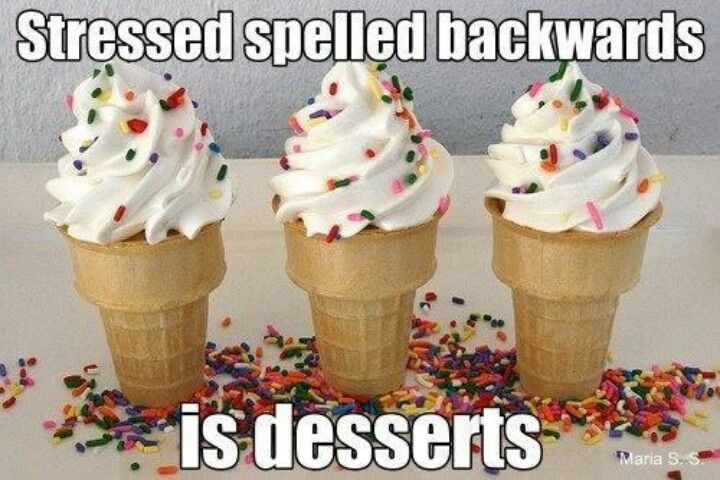

This is because it mixes all data together in the goal of producing one estimate. A lot of information is lost, making it harder to predict individual cases. Let's say we know that a pendulum is on planet one. That lends us no extra information compared to being agnostic about the position.

In [4]:
def pooled_model(pendulum_code, times, pos_obs=None):
    ## a_g is estimated globally in this model
    ## and the only plates are over the different pendulums, as before
    
    n_pendulums = len(np.unique(pendulum_code))
    μ_a_g = numpyro.sample("μ_a_g", dist.Uniform(1.0,20.0))
    σ_a_g = numpyro.sample("σ_a_g", dist.Uniform(0.0,5))
        
    a_g = numpyro.sample("a_g", dist.Normal(μ_a_g, σ_a_g))#10.0, 1.0))#
    
    with numpyro.plate("pend_i", n_pendulums):
        L = numpyro.sample("L", dist.Uniform(1,25))
        theta = numpyro.sample("theta", dist.Uniform(0,jnp.pi/2))

    σ = numpyro.sample("σ", dist.Exponential(2))
    modelx = L[pendulum_code] * jnp.sin(theta[pendulum_code] * jnp.cos(jnp.sqrt(a_g / L[pendulum_code]) * times))
    
    with numpyro.plate("data", len(pendulum_code)):
        pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)
        


The unpooled model is like a bunch of different ice cream cones:

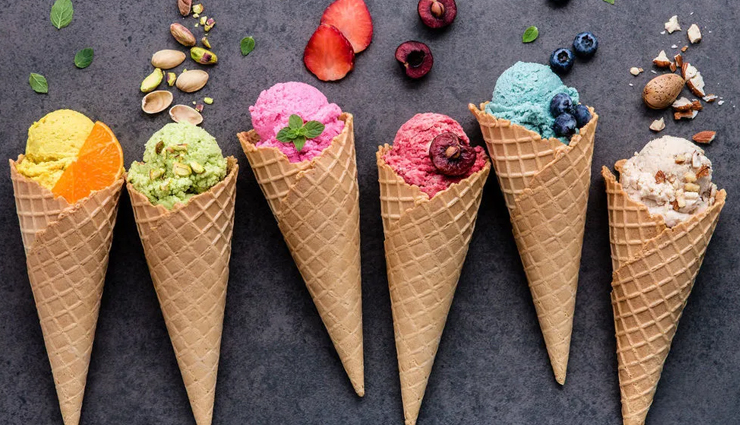

Here, the modeling is fully segmented for each planet (here, ice cream cone). This means the model has no mechanism (such as a global distribution characterized by μ_a_g and σ_a_g) to share information between groups.

In [5]:
def unpooled_model(planet_code, pendulum_code, times, pos_obs=None):
    
    n_planets = len(np.unique(planet_code))
    n_pendulums = len(np.unique(pendulum_code))
    
    with numpyro.plate("planet_i", n_planets):
        μ_a_g = numpyro.sample("μ_a_g", dist.Uniform(10.0,15.0))
        σ_a_g = numpyro.sample("σ_a_g", dist.Uniform(0.0,5))
        
        
        #dist.TruncatedNormal(beta_mean,beta_sigma,low=-1, high=0.8)
        #10.0, 1.0
        a_g = numpyro.sample("a_g", dist.TruncatedNormal(μ_a_g, σ_a_g, low = 0, high = 20))#dist.Uniform(13, 16))#

    with numpyro.plate("pend_i", n_pendulums):
        L = numpyro.sample("L", dist.Uniform(1,25))
        theta = numpyro.sample("theta", dist.Uniform(0,jnp.pi/2))

    σ = numpyro.sample("σ", dist.Exponential(20))#dist.HalfNormal(2.0))
    modelx = L[pendulum_code] * jnp.sin(theta[pendulum_code] * jnp.cos(jnp.sqrt(a_g[pendulum_code] / L[pendulum_code]) * times))
    
    with numpyro.plate("data", len(pendulum_code)):
        pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)

In [6]:
def ungrouped_model(pendulum_code, times, pos_obs=None):
    ## a_g is estimated globally in this model
    ## and the only plates are over the different pendulums, as before
    
    n_pendulums = len(np.unique(pendulum_code))
    μ_a_g = numpyro.sample("μ_a_g", dist.Uniform(1.0,20.0))
    σ_a_g = numpyro.sample("σ_a_g", dist.Uniform(0.0,5))
        
    
    
    with numpyro.plate("pend_i", n_pendulums):
        a_g = numpyro.sample("a_g", dist.Normal(μ_a_g, σ_a_g))#10.0, 1.0))#
        L = numpyro.sample("L", dist.Uniform(1,25))
        theta = numpyro.sample("theta", dist.Uniform(0,jnp.pi/2))

    σ = numpyro.sample("σ", dist.Exponential(2))
    modelx = L[pendulum_code] * jnp.sin(theta[pendulum_code] * jnp.cos(jnp.sqrt(a_g[pendulum_code] / L[pendulum_code]) * times))
    
    #with numpyro.plate("data", len(pendulum_code)):
    pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)
        


## Generate pendulum data
To do this make a dataframe and replicate a bunch of columns. There are 8 pendulums on two different planets. The planet_id and pendulum_id are integers denoting which pendulum and which planet each row of the dataframe belongs.

In [37]:
import deepbench
from deepbench.physics_object import Pendulum

# okay now make a dataframe with a bunch of different options for the parameters
# generate the L, theta, a_g values somewhat randomly between ranges
length_percent_error_all = 0.0
theta_percent_error_all = 0.0
a_g_percent_error_all = 0.0
pos_err = 0.0

time = 0.75

length_df = 100
xs = np.zeros((2*length_df, 3))
labels = np.zeros((2*length_df, 2))
y_noisy = []

for r in range(length_df):
    rs = np.random.RandomState()#2147483648)# 
    length = abs(rs.normal(loc=5, scale=1))
    theta = abs(rs.normal(loc=jnp.pi/100, scale=jnp.pi/200))
    a_g = 10.0#abs(rs.normal(loc=10, scale=1))
    xs[r,:] = [length, theta, a_g]
    labels[r,:] = [0, r]
    
    pendulum = Pendulum(
        pendulum_arm_length=length,
        starting_angle_radians=theta,
        acceleration_due_to_gravity=a_g,
        noise_std_percent={
            "pendulum_arm_length": length_percent_error_all,
            "starting_angle_radians": theta_percent_error_all,
            "acceleration_due_to_gravity": a_g_percent_error_all,
        },
    )
    y_noisy.append(pendulum.create_object(time, noiseless=False))
    del pendulum

# and do it again for a different a_g draw

for r in range(length_df):
    r = r + length_df
    rs = np.random.RandomState()#2147483648)# 
    length = abs(rs.normal(loc=5, scale=1))
    theta = abs(rs.normal(loc=jnp.pi/100, scale=jnp.pi/200))
    a_g = 15.0#abs(rs.normal(loc=15, scale=1))
    xs[r,:] = [length, theta, a_g]
    labels[r,:] = [1, r]
    
    pendulum = Pendulum(
        pendulum_arm_length=length,
        starting_angle_radians=theta,
        acceleration_due_to_gravity=a_g,
        noise_std_percent={
            "pendulum_arm_length": length_percent_error_all,
            "starting_angle_radians": theta_percent_error_all,
            "acceleration_due_to_gravity": a_g_percent_error_all,
        },
    )
    y_noisy.append(pendulum.create_object(time, noiseless=False))
    del pendulum

<Figure size 640x480 with 0 Axes>

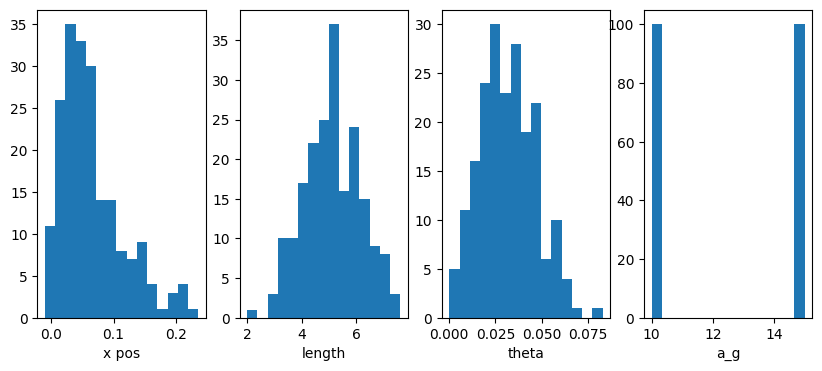

In [38]:
bins = 15

plt.clf()
fig = plt.figure(figsize = (10,4))
ax = fig.add_subplot(141)
ax.hist(y_noisy, bins=bins)
ax.set_xlabel('x pos')
ax1 = fig.add_subplot(142)
ax1.hist(xs[:,0], bins=bins)
ax1.set_xlabel('length')
ax2 = fig.add_subplot(143)
ax2.hist(xs[:,1], bins=bins)
ax2.set_xlabel('theta')
ax3 = fig.add_subplot(144)
ax3.hist(xs[:,2], bins=bins)
ax3.set_xlabel('a_g')
plt.show()

Now make this into a df with columns for planet number and pendulum number.

In [39]:
data_params = {
    'length': xs[:,0],
    'theta': xs[:,1],
    'a_g': xs[:,2],
    'planet_id': labels[:,0],
    'pendulum_id': labels[:,1]
    
}

## create the DataFrame
df = pd.DataFrame(data_params)
df['pos'] = y_noisy
df['time'] = np.repeat(time,2*length_df)

pend_encoder = LabelEncoder()
df["pend_code"] = pend_encoder.fit_transform(df["pendulum_id"].values)
planet_encoder = LabelEncoder()
df["planet_code"] = planet_encoder.fit_transform(df["planet_id"].values)

planet_code = df["planet_code"].values
pend_obs = df["pos"].values
time_values = df["time"].values
pend_code = df["pend_code"].values

df = df[["length","theta","a_g","pos","pend_code","planet_code","time"]]

df

length     theta   a_g       pos  pend_code  planet_code  time
0    4.163686  0.030765  10.0  0.050881          0            0  0.75
1    6.710301  0.020323  10.0  0.083094          1            0  0.75
2    3.520587  0.015524  10.0  0.016505          2            0  0.75
3    3.250509  0.034881  10.0  0.028634          3            0  0.75
4    4.516584  0.015491  10.0  0.030736          4            0  0.75
..        ...       ...   ...       ...        ...          ...   ...
195  5.124536  0.009962  15.0  0.014482        195            1  0.75
196  6.121352  0.058669  15.0  0.138767        196            1  0.75
197  4.602423  0.039591  15.0  0.039197        197            1  0.75
198  6.882439  0.006624  15.0  0.020385        198            1  0.75
199  5.605903  0.060077  15.0  0.113565        199            1  0.75

[200 rows x 7 columns]

## Visualize the probabilistic graph
Numpyro has some neat tools for creating DAGS - directive acyclic graphs

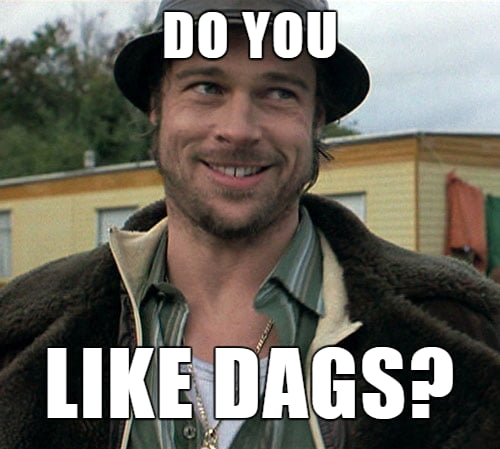

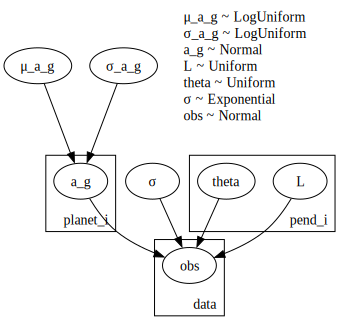

In [26]:
## first hierarchical
numpyro.render_model(
    model=hierarchical_model,
    model_args=(planet_code, pend_code, time_values),
    render_distributions=True,
    render_params=True,
)

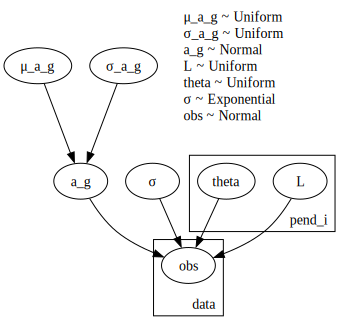

In [19]:
## full pooled
numpyro.render_model(
    model=pooled_model,
    model_args=(pend_code, time_values),
    render_distributions=True,
    render_params=True,
)

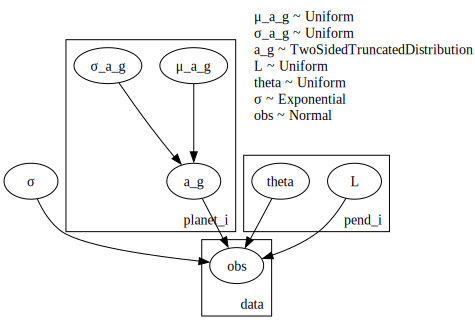

In [26]:
## unpooled
numpyro.render_model(
    model=unpooled_model,
    model_args=(planet_code, pend_code, time_values),
    render_distributions=True,
    render_params=True,
)

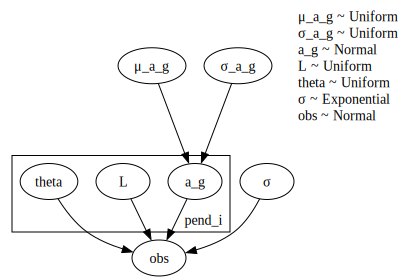

In [27]:
## new pooled
numpyro.render_model(
    model=ungrouped_model,
    model_args=(pend_code, time_values),
    render_distributions=True,
    render_params=True,
)

## Prior predictive distribution
Before running anything, investigate what the prior predictive distribution looks like. This is a way of drawing from the priors that you have set up to see if they are reasonable compared to the data.

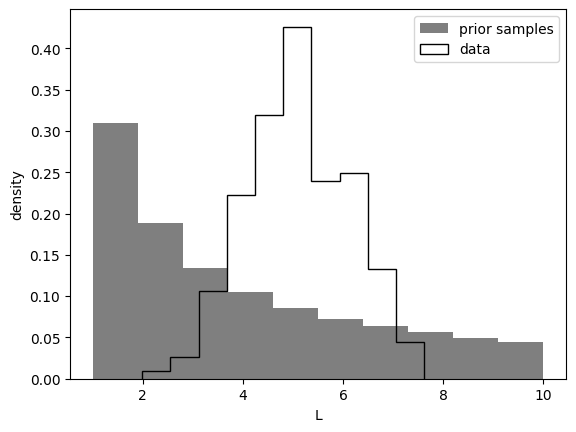

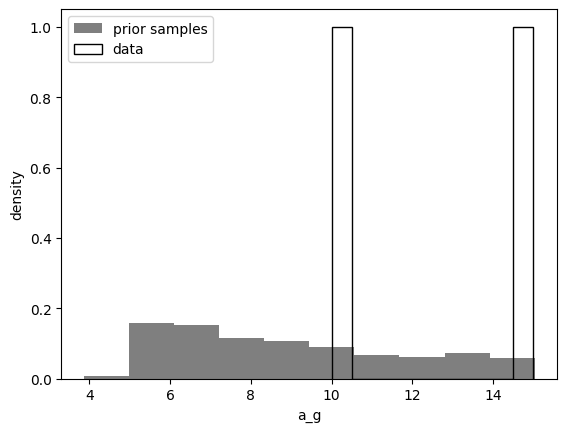

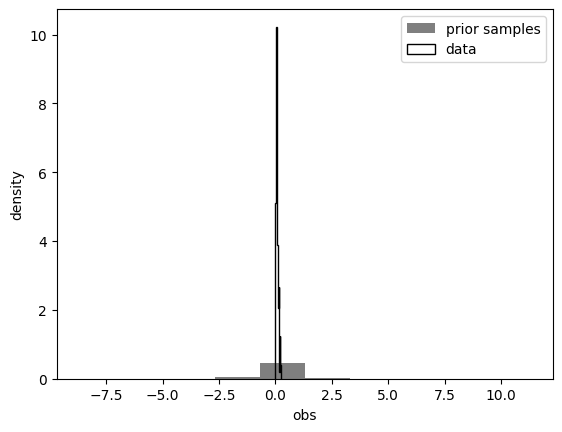

KeyError: 'σ'

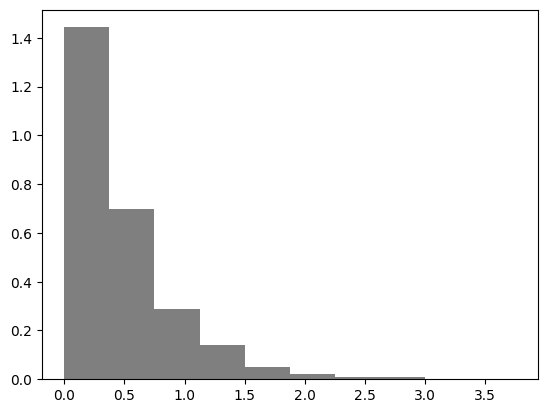

In [47]:
## generate samples from the prior using numpyro.infer.Predictive
## we will give it all the same inputs as the dataset, but this could be done with
## a new dataset

prior_pred = numpyro.infer.Predictive(hierarchical_model, num_samples=1000)(
    random.PRNGKey(11), planet_code, pend_code, time_values
)

## the plot_prior_predictive helper graph function normalizes the density
## of the true and sampled parameter values so that they each sum to one
plot_prior_predictive(prior_pred, "L", "length", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "a_g", "a_g", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "obs", "pos", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "σ", "σ", n_steps=10, title = None)


## Run the inference for the hierarchical case

In [48]:
## the NUTS (no u-turn sampler) is a type of hamiltonian monte carlo
## method, meaning it knows about potential energy (think gradients)
nuts_kernel = NUTS(hierarchical_model, init_strategy = numpyro.infer.initialization.init_to_sample)#, target_accept_prob = 0.9)

# can change the target acceptance probability
# default is 0.8 80% 
mcmc_hierarchical = MCMC(nuts_kernel, num_samples=5000, num_warmup=1000, num_chains = 4)
rng_key = random.PRNGKey(11)
mcmc_hierarchical.run(rng_key, planet_code, pend_code, time_values, pos_obs=pend_obs)

posterior_samples_hierarchical = mcmc_hierarchical.get_samples()

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [49]:
## the arviz tools allows us to investigate the chain performance
inf_data = az.from_numpyro(mcmc_hierarchical)
## zero divergence means energy is conserved
print(f'divergences: {inf_data.sample_stats.diverging.values.sum()}')
az.summary(inf_data)

divergences: 0


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
L[0]        3.581  2.263   1.001    8.269      0.351    0.250      69.0   
L[1]        3.969  2.322   1.477    8.765      0.585    0.422      13.0   
L[2]        2.310  1.677   1.000    5.745      0.355    0.254      12.0   
L[3]        3.113  1.884   1.000    7.084      0.113    0.108     494.0   
L[4]        3.236  1.910   1.000    7.114      0.052    0.085    1147.0   
...           ...    ...     ...      ...        ...      ...       ...   
theta[198]  0.013  0.011   0.003    0.036      0.001    0.001      61.0   
theta[199]  0.026  0.014   0.007    0.054      0.003    0.002      13.0   
μ_a_g       5.597  0.787   5.000    7.124      0.387    0.296       7.0   
σ           0.030  0.027   0.007    0.081      0.013    0.010       7.0   
σ_a_g       0.709  0.412   0.000    0.995      0.205    0.157       7.0   

            ess_tail  r_hat  
L[0]          3777.0   1.04  
L[1]           277.0   1.20  
L[2]           636.0   1.24  
L[3]           929.0   1.14  
L[4]           961.0   1.13  
...              ...    ...  
theta[198]     635.0   1.04  
theta[199]      29.0   1.22  
μ_a_g           12.0   1.59  
σ               11.0   1.58  
σ_a_g           14.0   1.55  

[405 rows x 9 columns]

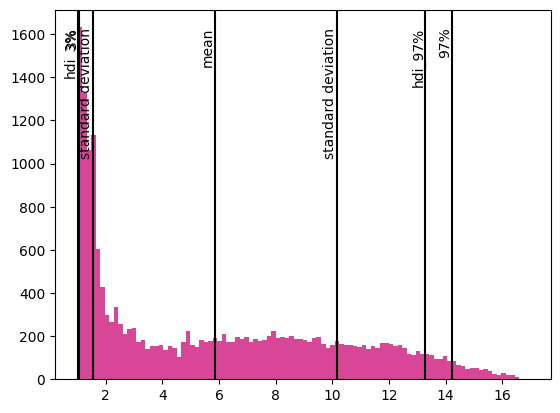

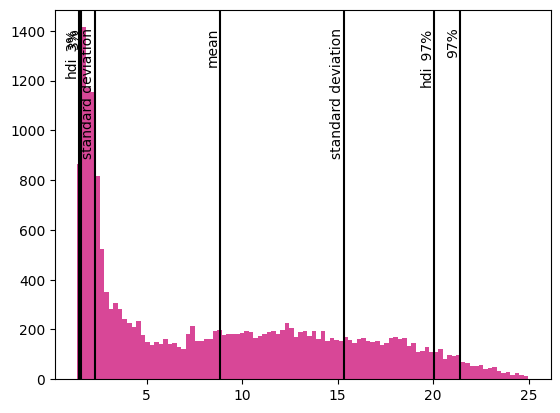

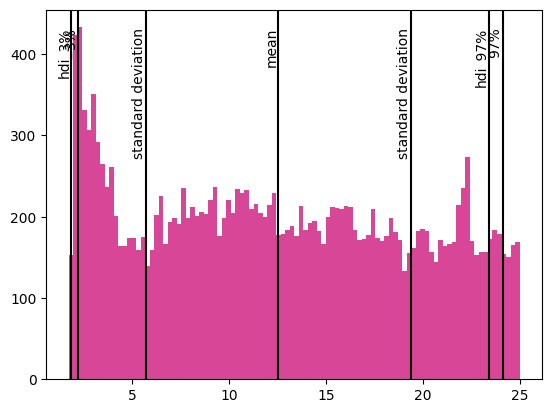

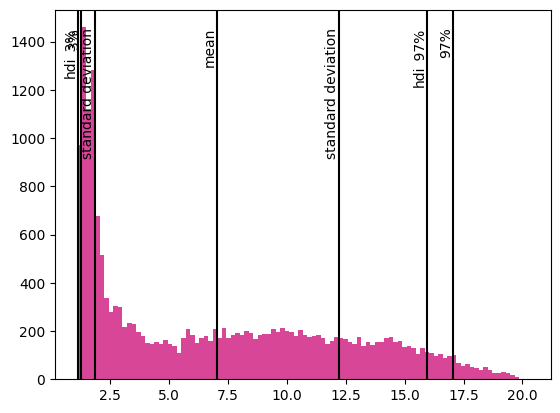

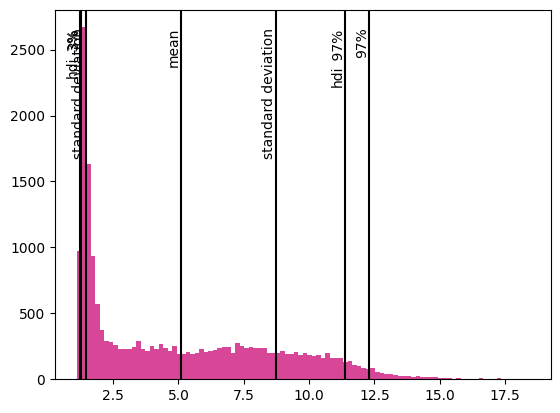

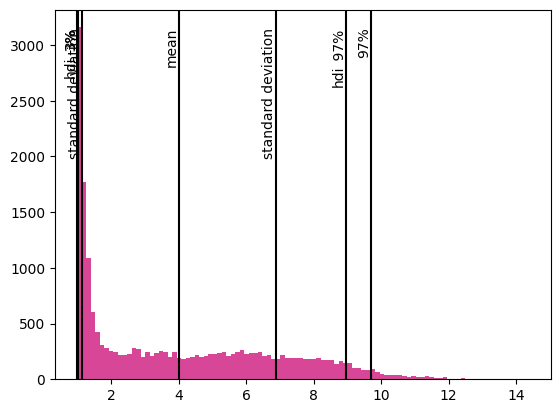

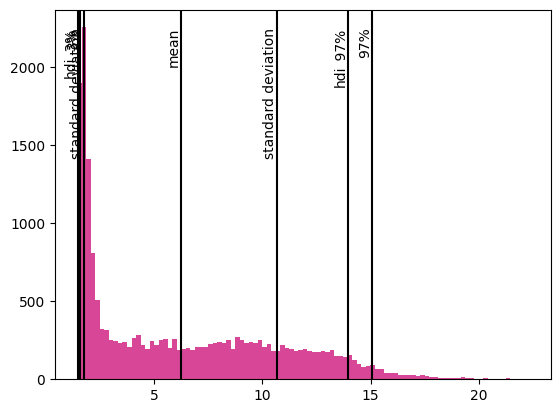

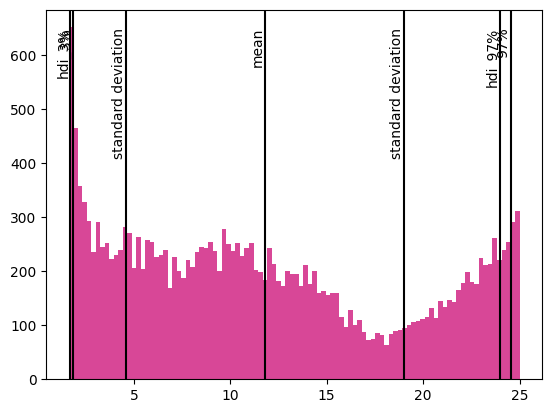

In [19]:
investigate_distribution_posteriors(posterior_samples_hierarchical, inf_data)

## Interpreting the arviz table
The first two columns are the mean and standard deviation of each parameter, taken from examining all four chains.

- hdi = the high density interval, which is the minimum width Bayesian credible interval (BCI)

The best description I've found for it:

The HDI is the interval which contains the required mass such that all points within the interval have a higher probability density than points outside the interval. In contrast, a symmetric density interval defined by (eg.) the 10% and 90% quantiles may include values with lower probability than those excluded.


- mcse = markov chain standard error

- ess = effective sample size

This is equal to the sample size if all samples are independent. Here, the values are quite low for the different parameters, which indicates that we have very few indpendent draws. Does this mean we need to length the chains? Maybe.

- rhat = rank normalized splitR-hat for a set of traces (https://arxiv.org/pdf/1903.08008.pdf)

The rank normalized R-hat diagnostic tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identical. To be most effective in detecting evidence for nonconvergence, each chain should have been initialized to starting values that are dispersed relative to the target distribution.

rhat ~ sqrt(1 + Nchains/ESS), 


so ESS/Nchains ~ 1/2/(rhat - 1), which means that if rhat = 1.05 then ESS/Nchains = 10, which isn’t very big

<Figure size 640x480 with 0 Axes>

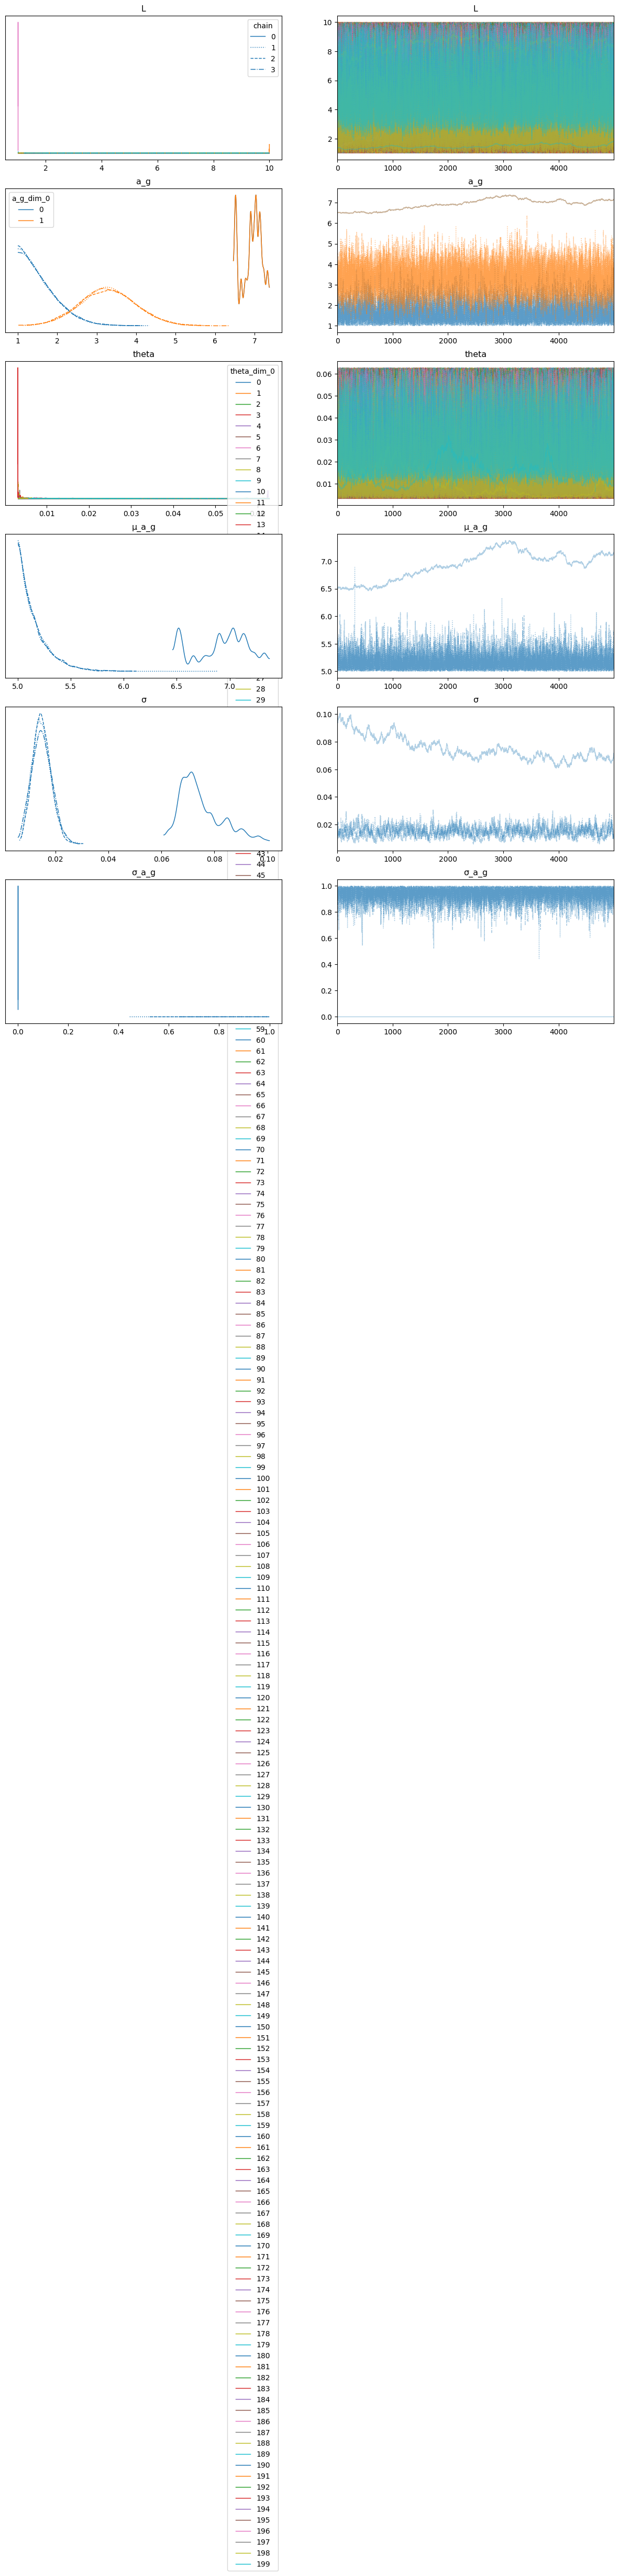

In [50]:
data = az.from_numpyro(mcmc_hierarchical)
plt.clf()
az.plot_trace(data, compact=True, figsize=(15, 25), legend=True)
plt.show()

## Visualize it
Some of the classic ways to visualize the output don't work super well with a million pendulums

In [51]:
# so there are sampler chains for each group
print('shape of L samples', np.shape(mcmc_hierarchical.get_samples()['L']))
print('shape of a_g samples', np.shape(mcmc_hierarchical.get_samples()['a_g']))

shape of L samples (20000, 200)
shape of a_g samples (20000, 2)


In [52]:
posterior_hierarchical = mcmc_hierarchical.get_samples()

ValueError: Provided figure has 64 axes, but data has dimensions K=200

<Figure size 640x480 with 0 Axes>

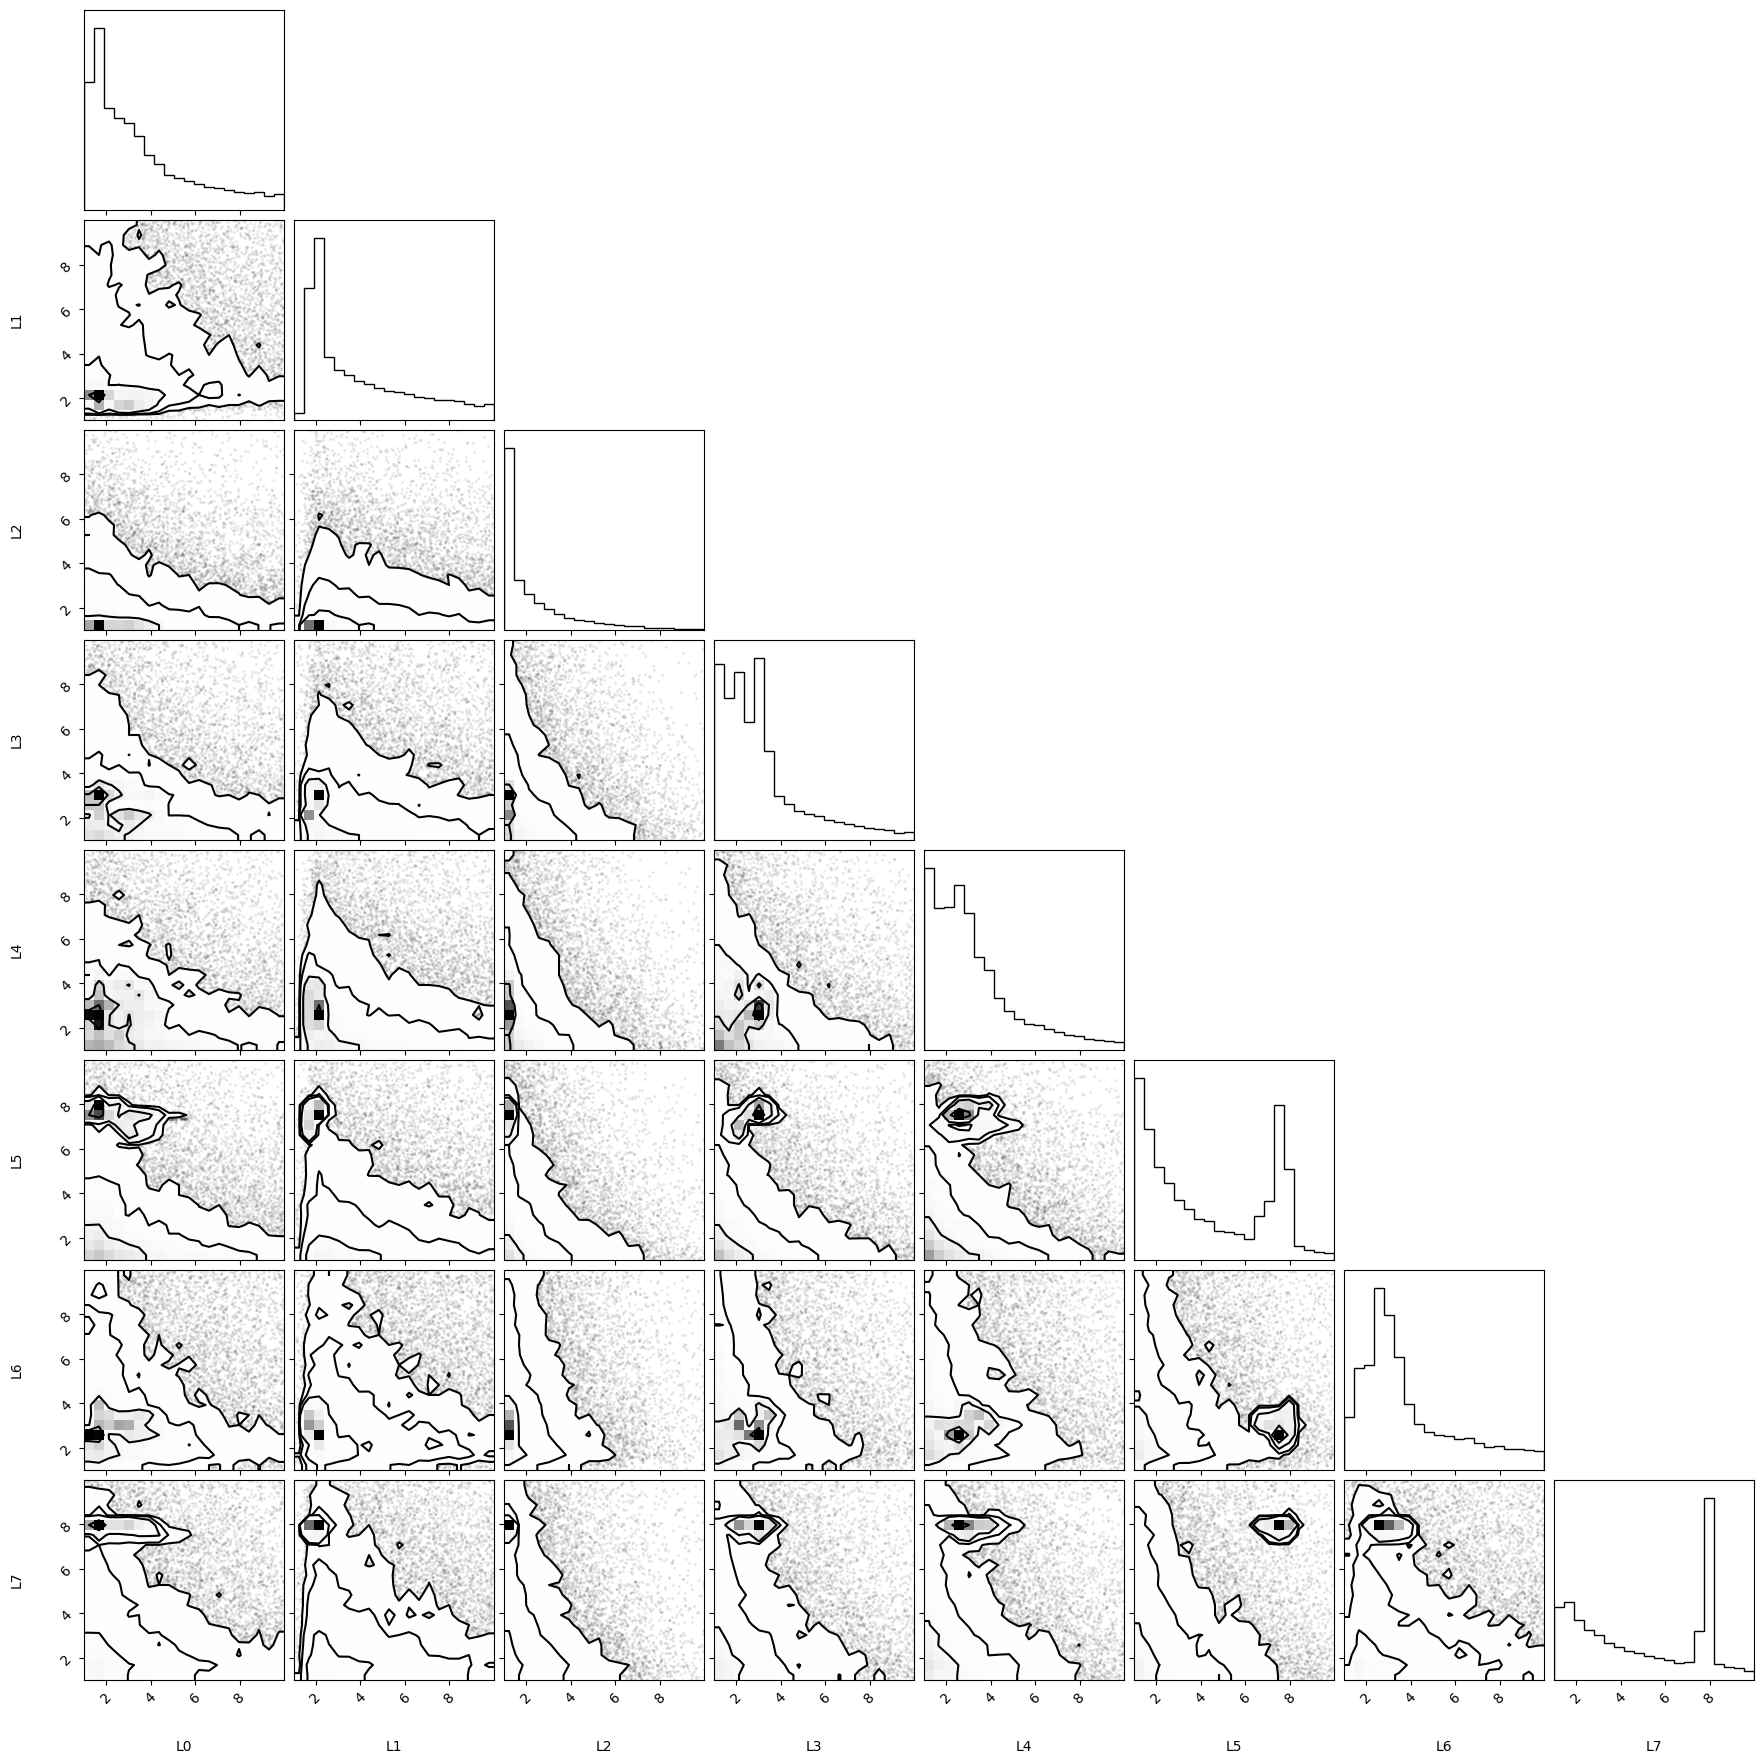

In [53]:
# take a look at the posterior
make_corner_plots(posterior_hierarchical, data_params)

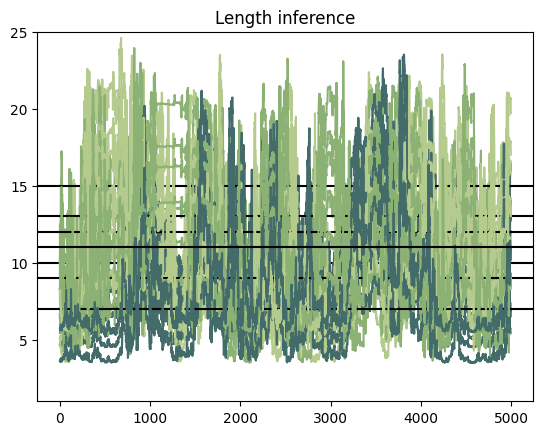

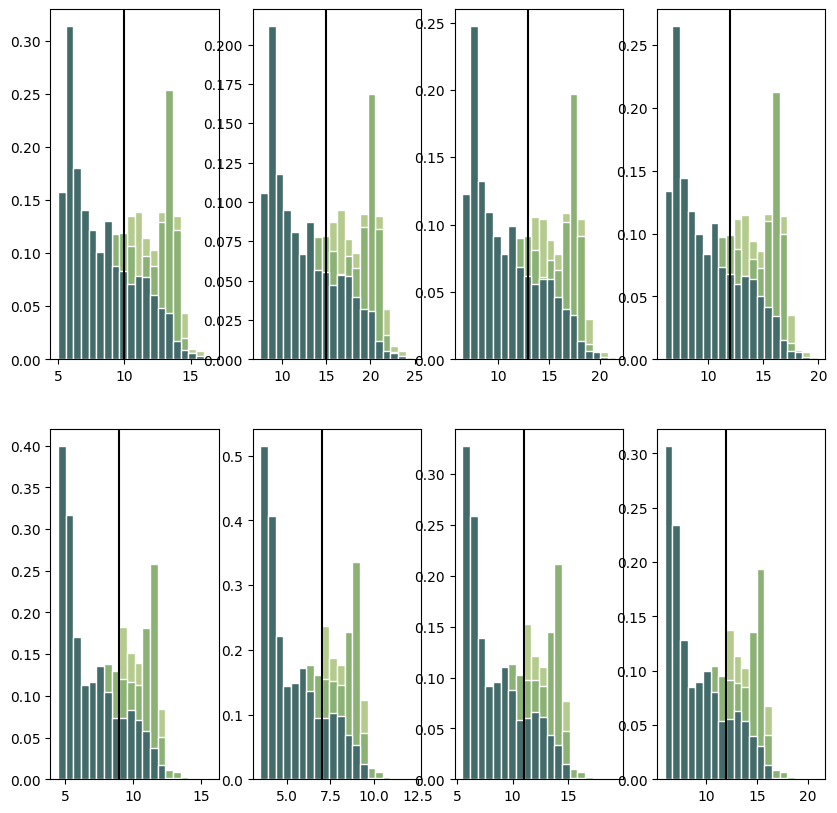

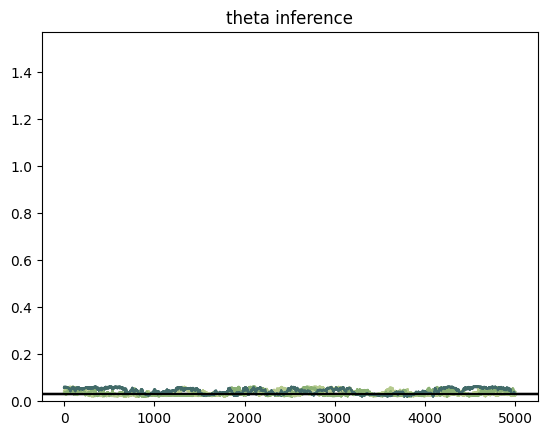

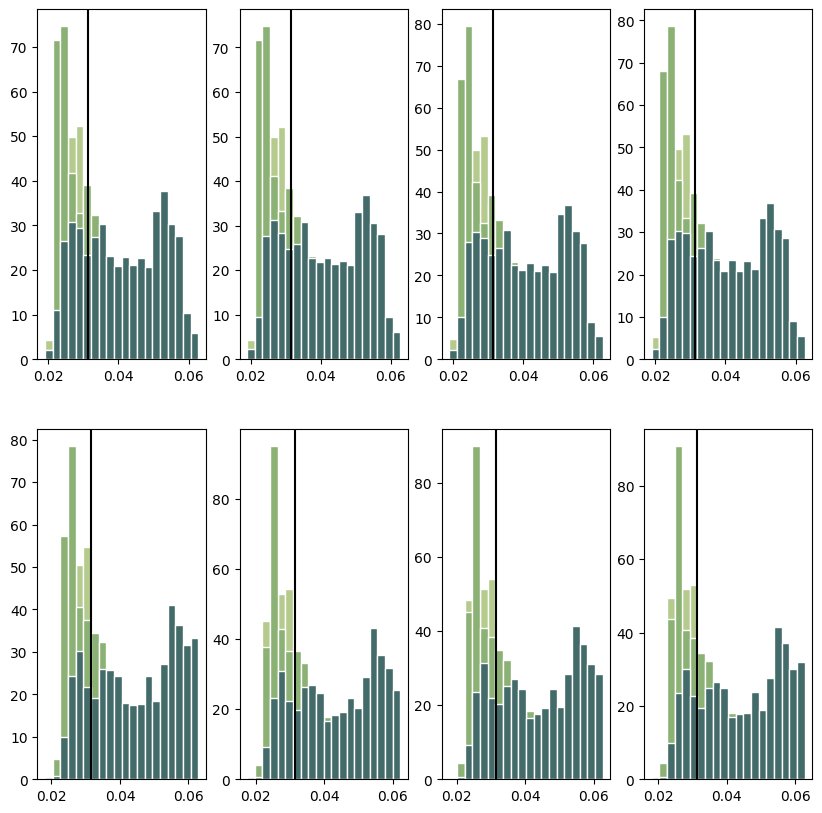

In [44]:
# Let's come up with a better way to show all seven pendulums sampling result in histogram form
# for the separate 4 chains
#def examine_chains(posterior, data_params, n_pendulums = 8, chain_length = 5000, n_chains = 4):

examine_chains(posterior_hierarchical, data_params)


In [ ]:
# how did we do at predicting the trajectory?
#how_did_we_do_on_individual_pendulums(df, posterior, 8, 2000)
how_did_we_do_on_all_pendulums(df, posterior_hierarchical, 8, 2000)

In [ ]:
# plot the posterior predictive samples
# get posterior predictive samples

hierarachical_posterior_predictive, hierarchical_posterior_predictive_samples, hierarchical_idata = plot_posterior_predictive_samples(df,
                                  hierarchical_model,
                                  posterior_hierarchical,
                                  rng_key,
                                  time_values,
                                  mcmc_hierarchical,
                                  pooled = False,
                                  title = "Hierarchical Model Posterior Predictive Check")

In [ ]:
# plot for each individual planet
print(hierarachical_posterior_predictive)
print(hierarchical_posterior_predictive_samples)
print(np.shape(posterior_hierarchical['L'][:,0]))


nbins = 20

plt.clf()
value, bin_center = np.histogram(hierarchical_posterior_predictive_samples['obs'].flatten()[:], bins = nbins)
plt.hist(hierarchical_posterior_predictive_samples['obs'].flatten()[:],
         bins = bin_center,
         color = '#6C969D', alpha = 0.5,
         label = 'Model posterior', 
         density = True,
         histtype='bar', ec='white')
plt.hist(df["pos"].values,
         bins = bin_center,
         color = '#99D5C9', alpha = 0.5,
         label = 'Obs',
         density = True,
         histtype='bar', ec='white')
plt.legend()
plt.show()

STOP
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(10, 6), sharex=False, sharey=False, layout="constrained"
)

axes = axes.flatten()

for location in range(1, 2 + 1):
    ax = axes[location - 1]
    sns.histplot(
        x=hierarchical_posterior_predictive_samples["a_g"][:, location - 1],
        color=f"C{location - 1}",
        ax=ax,
    )
    ax.set(title=f"Planet {location}", xlabel="a_g", ylabel="count")

fig.suptitle("Hierarchical Model Prior Predictive Samples", y=1.05, fontsize=16)

## Now run the inference for the ungrouped case

In [47]:
# higher acceptance means smaller step size
# Target acceptance probability for step size adaptation using Dual Averaging. 
# Increasing this value will lead to a smaller step size, hence the sampling will be slower but more robust.
# Defaults to 0.8.
nuts_kernel_ungrouped = NUTS(ungrouped_model, target_accept_prob = 0.8)

mcmc_unpooled = MCMC(nuts_kernel_ungrouped, num_samples=5000, num_warmup=5000, num_chains = 4)
rng_key = random.PRNGKey(11)
mcmc_unpooled.run(rng_key, pend_code, time_values, pos_obs=pend_obs)


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [49]:
inf_data_ungrouped = az.from_numpyro(mcmc_unpooled)
az.summary(inf_data_ungrouped)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
L[0]       5.922  3.276   1.005   11.788      1.033    0.753      10.0   
L[1]       9.045  4.880   1.163   17.643      1.541    1.123      10.0   
L[2]      13.367  7.504   1.013   22.065      3.061    2.295       7.0   
L[3]      13.409  7.640   1.047   22.412      3.236    2.434       7.0   
L[4]       4.593  2.654   1.002    9.925      0.777    0.564      12.0   
L[5]       5.034  3.136   1.118    9.189      1.352    1.037       7.0   
L[6]       6.730  3.684   1.002   11.998      1.305    0.959       9.0   
L[7]       8.431  5.350   1.518   15.367      2.279    1.734       7.0   
a_g[0]     5.733  5.574  -0.066   16.523      2.164    1.603       6.0   
a_g[1]     5.623  5.657  -0.605   16.396      2.231    1.655       6.0   
a_g[2]     5.267  5.257   0.067   16.183      2.124    1.580       6.0   
a_g[3]     4.892  5.516   0.078   16.213      2.292    1.711       5.0   
a_g[4]     6.206  5.201   1.453   16.571      1.904    1.403       6.0   
a_g[5]     5.415  5.977  -1.743   16.314      2.457    1.831       6.0   
a_g[6]     5.323  6.097  -1.998   16.311      2.496    1.859       6.0   
a_g[7]     6.053  5.250   1.216   16.388      1.936    1.427       6.0   
theta[0]   0.132  0.089   0.025    0.254      0.038    0.029       7.0   
theta[1]   0.142  0.104   0.025    0.286      0.045    0.034       7.0   
theta[2]   0.366  0.534   0.004    1.285      0.266    0.204       5.0   
theta[3]   0.310  0.445   0.003    1.074      0.221    0.170       5.0   
theta[4]   0.396  0.525   0.028    1.301      0.262    0.201       6.0   
theta[5]   0.301  0.373   0.028    0.942      0.185    0.143       6.0   
theta[6]   0.233  0.246   0.028    0.646      0.120    0.094       6.0   
theta[7]   0.416  0.552   0.029    1.365      0.274    0.211       6.0   
μ_a_g      7.996  4.114   1.705   15.816      1.501    1.105       8.0   
σ          0.092  0.054   0.010    0.160      0.027    0.021       4.0   
σ_a_g      2.804  1.338   0.263    4.779      0.262    0.187      58.0   

          ess_tail  r_hat  
L[0]          48.0   1.32  
L[1]          61.0   1.32  
L[2]          27.0   1.55  
L[3]          28.0   1.60  
L[4]          68.0   1.61  
L[5]         140.0   1.62  
L[6]          58.0   1.38  
L[7]         119.0   1.60  
a_g[0]         4.0   1.93  
a_g[1]         4.0   1.92  
a_g[2]        29.0   1.78  
a_g[3]         4.0   2.24  
a_g[4]         4.0   1.91  
a_g[5]         4.0   1.92  
a_g[6]         4.0   1.92  
a_g[7]         4.0   1.93  
theta[0]      52.0   1.65  
theta[1]      62.0   1.64  
theta[2]      26.0   2.65  
theta[3]      26.0   2.94  
theta[4]      76.0   1.90  
theta[5]      62.0   1.90  
theta[6]      60.0   1.91  
theta[7]      61.0   1.92  
μ_a_g         49.0   1.49  
σ             29.0   3.17  
σ_a_g       1087.0   1.09

/Users/rnevin/Library/Caches/pypoetry/virtualenvs/deepuq-DRzT0TL8-py3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/rnevin/Library/Caches/pypoetry/virtualenvs/deepuq-DRzT0TL8-py3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/rnevin/Library/Caches/pypoetry/virtualenvs/deepuq-DRzT0TL8-py3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/rnevin/Library/Caches/pypoetry/virtualenvs/deepuq-DRzT0TL8-py3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: Us

<Figure size 640x480 with 0 Axes>

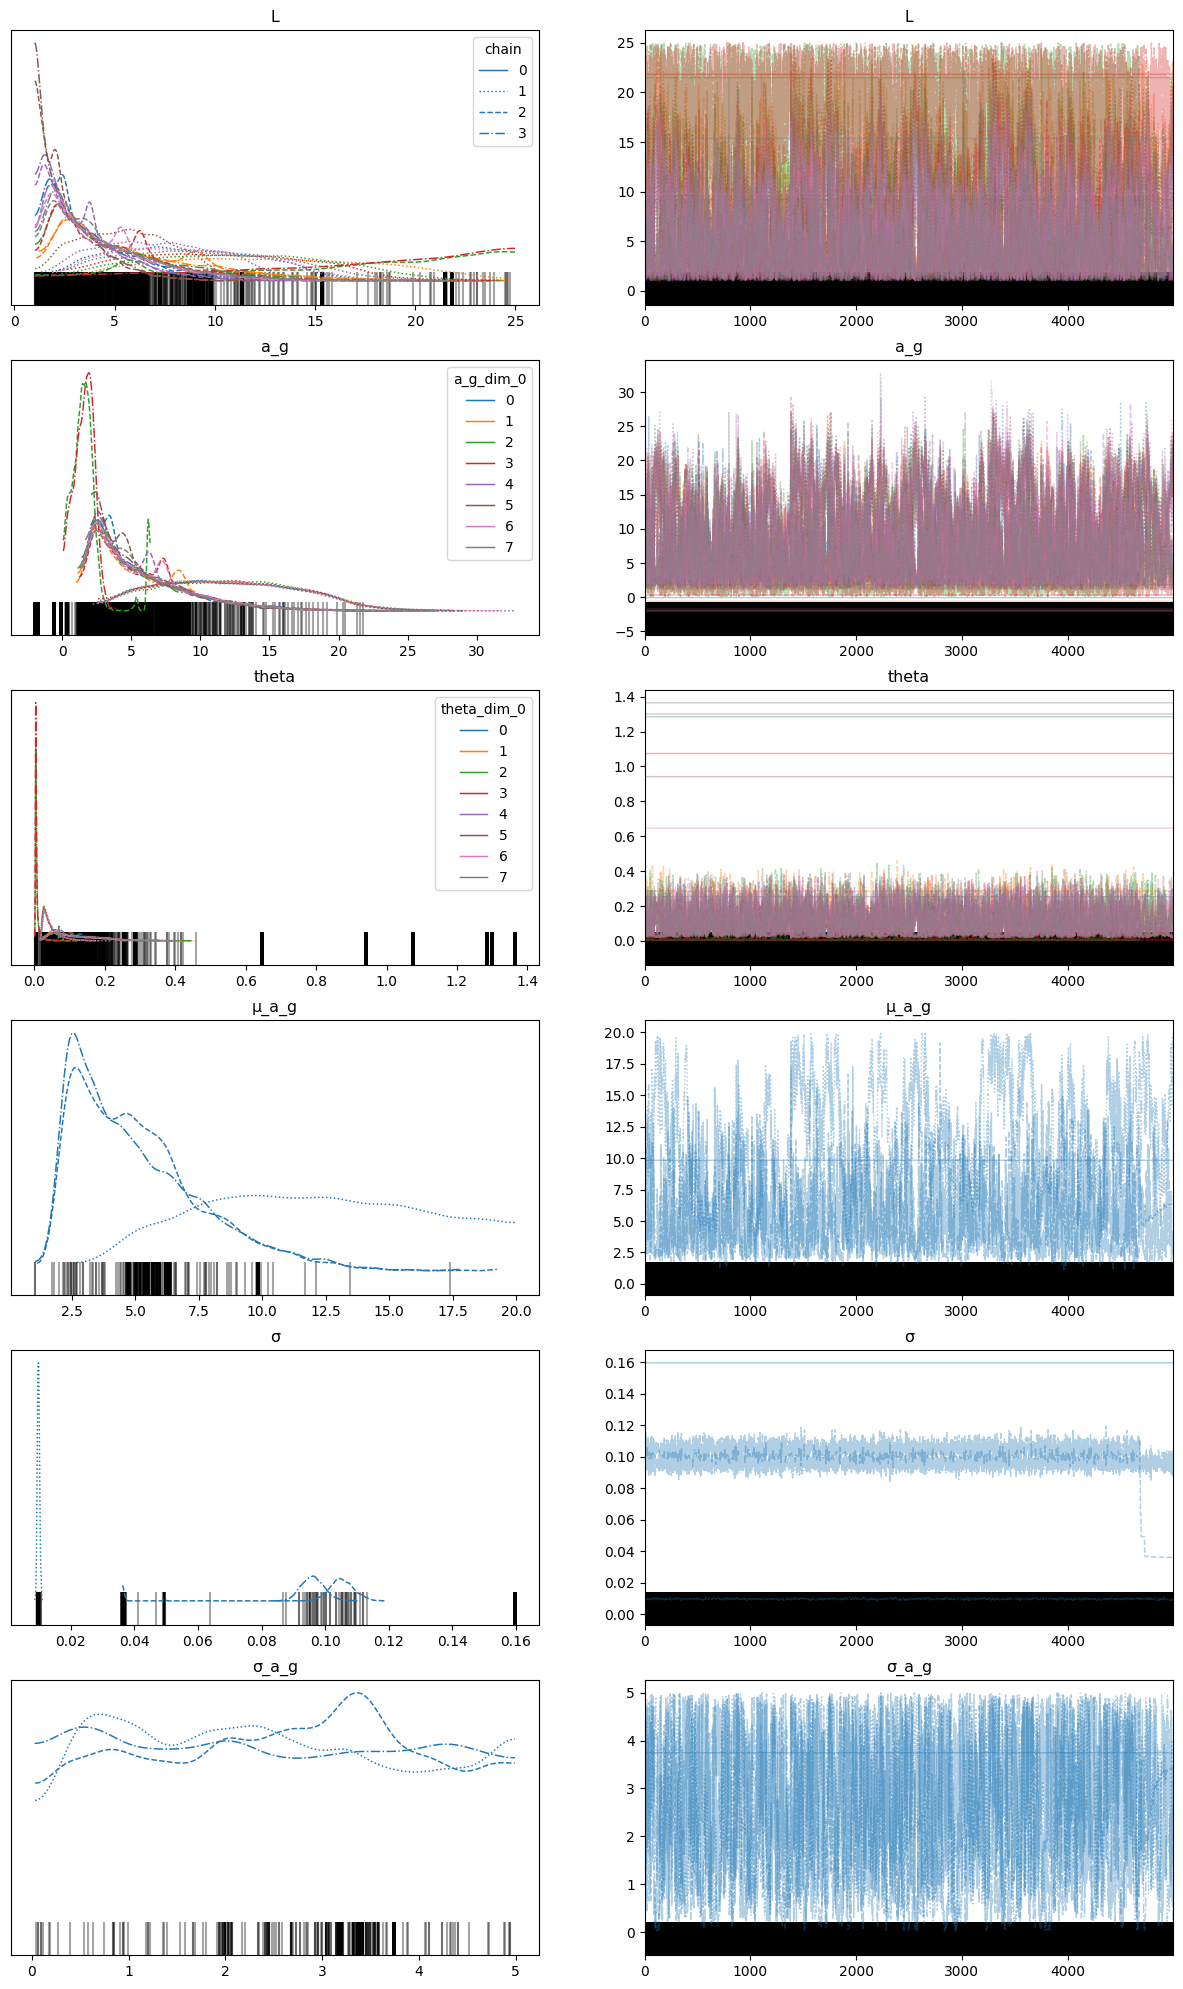

In [51]:
data_ungrouped = az.from_numpyro(mcmc_unpooled)
plt.clf()
az.plot_trace(data_ungrouped, compact=True, figsize=(15, 25), legend=True)
plt.show()

In [ ]:
posterior_ungrouped = mcmc_ungrouped.get_samples()

In [ ]:
# take a look at the posterior
make_corner_plots(posterior_ungrouped, data_params)

## Now run the inference for the unpooled (non-hierarchical) case

In [ ]:
# higher acceptance means smaller step size
# Target acceptance probability for step size adaptation using Dual Averaging. 
# Increasing this value will lead to a smaller step size, hence the sampling will be slower but more robust.
# Defaults to 0.8.
nuts_kernel_unpooled = NUTS(unpooled_model, target_accept_prob = 0.8)

mcmc_unpooled = MCMC(nuts_kernel_unpooled, num_samples=5000, num_warmup=5000, num_chains = 4)
rng_key = random.PRNGKey(11)
mcmc_unpooled.run(rng_key, planet_code, pend_code, time_values, pos_obs=pend_obs)


In [ ]:
inf_data_unpooled = az.from_numpyro(mcmc_unpooled)
az.summary(inf_data_unpooled)

In [ ]:
data_unpooled = az.from_numpyro(mcmc_unpooled)
plt.clf()
az.plot_trace(data_unpooled, compact=True, figsize=(15, 25), legend=True)
plt.show()

In [ ]:
posterior_unpooled = mcmc_unpooled.get_samples()

In [ ]:
# take a look at the posterior
make_corner_plots(posterior_unpooled, data_params)

In [ ]:
examine_chains(posterior_unpooled, data_params, chain_length = 5000)

In [ ]:
# there is something bad going on with this posterior
# "too few points to create valid contours"
investigate_distribution_posteriors(posterior_unpooled, inf_data_unpooled)


In [ ]:
# how did we do at predicting the trajectory?
#how_did_we_do_on_individual_pendulums(df, posterior_unpooled, 8, 2000)
how_did_we_do_on_all_pendulums(df, posterior_unpooled, 8, 2000)

In [ ]:
# plot the posterior predictive samples
# get posterior predictive samples

unpooled_posterior_predictive, unpooled_posterior_predictive_samples, unpooled_idata = plot_posterior_predictive_samples(df,
                                  unpooled_model,
                                  posterior_unpooled,
                                  rng_key,
                                  time_values,
                                  mcmc_unpooled,
                                  pooled = False,
                                  kind = "kde",
                                  title = "Unpooled Model Posterior Predictive Check",
                                                  )

## Trying the fully pooled model

In [ ]:
nuts_kernel_pooled = NUTS(pooled_model)

mcmc_pooled = MCMC(nuts_kernel_pooled, num_samples=5000, num_warmup=5000, num_chains = 4)
rng_key = random.PRNGKey(11)
mcmc_pooled.run(rng_key, pend_code, time_values, pos_obs=pend_obs)


In [ ]:
inf_data_pooled = az.from_numpyro(mcmc_pooled)
az.summary(inf_data_pooled)

In [ ]:
data_pooled = az.from_numpyro(mcmc_pooled)
plt.clf()
az.plot_trace(data_pooled, compact=True, figsize=(15, 25), legend=True)
plt.show()

In [ ]:
posterior_pooled = mcmc_pooled.get_samples()

In [ ]:
# take a look at the posterior
make_corner_plots(posterior_pooled, data_params, pooled = True)

In [ ]:
examine_chains(posterior_pooled, data_params)

In [ ]:
# how did we do at predicting the trajectory?
#how_did_we_do_on_individual_pendulums(df, posterior_pooled, 8, 2000, pooled = True)
how_did_we_do_on_all_pendulums(df, posterior_pooled, 8, 2000)

In [ ]:
# plot the posterior predictive samples
# get posterior predictive samples
pooled_idata = plot_posterior_predictive_samples(df,
                                  pooled_model,
                                  posterior_pooled,
                                  rng_key,
                                  time_values,
                                  mcmc_pooled,
                                  pooled = True,
                                  kind = 'kde',
                                  title = "Pooled Model Posterior Predictive Check",
                                  )

## Lets compare all models

In [ ]:
# What is a posterior predictive check?
# comparing the cumulative x positions from the data to those generated from 
# the posterior distribution
# some say this is using the data twice - 1. to generate the thetas, 2. to check again
compare_models(pooled_idata, unpooled_idata, hierarchical_idata, kind = 'cumulative')

In [ ]:
def pos_calculator_integer(L, theta, a_g, sigma, time):
    print('this is the cosine arg', np.sqrt(a_g / L), 'cosine of this', np.cos(np.sqrt(a_g / L)))
    print('this is the sine arg', theta * np.cos(np.sqrt(a_g / L)) * time, 'sine of this', np.sin(theta * np.cos(np.sqrt(a_g / L)) * time))
    pos = L * np.sin(theta * np.cos(np.sqrt(a_g / L) * time)) + sigma
    return pos

'''
theta_time = starting_angle_values * np.cos(
            np.sqrt(acceleration_values / pendulum_arm_length_values)
        )

        # Calculate x using the modified parameters and time
        return pendulum_arm_length_values * np.sin(theta_time * time)

'''
L = 10
theta = np.pi / 2
a_g = 10
sigma = 0.05
times = 0
print(pos_calculator_integer(L,theta,a_g,sigma,times))